# Первые пипы и импорты

In [ ]:
%pip install torch==1.9.1+cu111 torchvision==0.10.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html
%pip install pandas==1.3.3 pytorch-fid==0.2.1


In [1]:
import torch.nn.functional as F
import torch.nn as nn
import torch
import torchvision.transforms.functional as F_
import numpy as np
import os

# Модель генератора
Немного преобразованный код из моего МДЗ5

In [2]:
class DownBlock(nn.Module): #6.1
    def __init__(self, 
                 input_ch, 
                 output_ch, 
                 kernel_size=4,
                 stride=2,
                 padding=1,
                 norm=True,
                 slope=0.2):
        super(DownBlock, self).__init__()
        self.input_ch, self.output_ch = input_ch, output_ch
        conv_list = [nn.Conv2d(input_ch, 
                               output_ch, 
                               kernel_size,
                               stride,
                               padding,
                               bias=False)]
        if norm:
            #conv_list.append(nn.BatchNorm2d(output_ch))
            '''This approach to batch normalization, when the
batch size is set to 1, has been termed instance normalization'''
            conv_list.append(nn.InstanceNorm2d(output_ch))
        conv_list.append(nn.LeakyReLU(slope)) #All ReLUs in the encoder are leaky, with slope 0.2
        
        self.conv_net = nn.Sequential(*conv_list)
    def forward(self, x):
        x = self.conv_net(x)
        return x



class UpBlock(nn.Module):
    def __init__(self, 
                 input_ch, 
                 output_ch, 
                 kernel_size=4,
                 stride=2,
                 padding=1,
                 dropout=0.0
                 #norm=True,
                 #slope=0.2
                 ):
        super(UpBlock, self).__init__()
        self.input_ch, self.output_ch, self.dropout = input_ch, output_ch, dropout
        conv_list = [nn.ConvTranspose2d(input_ch, 
                               output_ch, 
                               kernel_size,
                               stride,
                               padding,
                               bias=False)] #Это вместо upsample, в мдз он не пошел
        
        conv_list.append(nn.InstanceNorm2d(output_ch))
        conv_list.append(nn.ReLU()) #while ReLUs in the decoder are not leaky
        if dropout > 0:
            conv_list.append(nn.Dropout(dropout))
        self.conv_net = nn.Sequential(*conv_list)
    def forward(self, x, skip_conn):
        x = self.conv_net(x)
        return torch.cat((x, skip_conn), 1) 





In [3]:
class UNetModel(nn.Module):
    def __init__(self, input_ch=3, #Так как rgb
                 output_ch=3, 
                 #encoder_dims=[64,128,256,512,512,512,512,512],
                 #decoder_dims=[512, 1024, 1024, 1024, 1024, 512, 256, 128 ],
                 #decoder_dropout=[0.5, 0.5, 0.5, 0.5, 0.0, 0.0, 0.0]
                 kernel_size=4,
                 padding=1):
    #encoderC64-C128-C256-C512-C512-C512-C512-C512
    

        super(UNetModel, self).__init__()

        self.input_block = DownBlock(input_ch, 64, norm=False)
        e_list = [DownBlock(64, 128),
                  DownBlock(128, 256),
                  DownBlock(256, 512),
                  DownBlock(512, 512),
                  DownBlock(512, 512),
                  DownBlock(512, 512),
                  DownBlock(512, 512, norm=False)#Здесь надо отключить нормализацию, т.к. ругается, что 1*1
                                        ]
        self.encoders = nn.ModuleList(e_list)

        d_list = [UpBlock(512, 512, dropout=0.5),
                  UpBlock(1024, 512, dropout=0.5),
                  UpBlock(1024, 512, dropout=0.5),
                  UpBlock(1024, 512, dropout=0.5),
                  UpBlock(1024, 256),
                  UpBlock(512, 128),
                  UpBlock(256, 64)]
        self.decoders = nn.ModuleList(d_list)


        self.output_block = nn.Sequential(
            nn.Upsample(scale_factor=2),
                       nn.ZeroPad2d((1, 0, 1, 0)),
                       nn.Conv2d(128, output_ch, kernel_size, padding=padding),
                       nn.Tanh()
             )

    def forward(self, x):
        x = self.input_block(x)
        copied_input = [x]
        for ii, layer in enumerate(self.encoders):
            #print('layer ', layer.input_ch, layer.output_ch)
            #print('input', x.shape)
            x = layer(x)
            #print('output', x.shape)
            copied_input.append(x)
        #print('Decoders')
        for ii, layer in enumerate(self.decoders):
             #print('layer ', layer.input_ch, layer.output_ch)
             #print('input', x.shape, copied_input[-ii - 2].shape)
             x = layer(x, copied_input[-ii - 2])
             #print('output', x.shape)

        #print(x.shape)
        x = self.output_block(x)
        #print(x.shape)
        return x


# Датасет


Здесь привожу финальный вид датасета, с добавленным применением аугов

In [4]:
import PIL
import os
import pandas as pd
import torchvision
import numpy as np
class ImageTrainDataSet(torch.utils.data.Dataset):
    def __init__(self,  folder_with_images, transform=None, aug=True, color_transform=None):
        self.folder_with_images = folder_with_images
        
        self.list_of_names = os.listdir(self.folder_with_images)
        self.transform = transform
        self.color_transform = color_transform
        self.aug=aug
        
    def __len__(self):
        return len(self.list_of_names)
    
    def __getitem__(self, i):
    
        name = self.list_of_names[i]
        
        xy = PIL.Image.open(os.path.join(self.folder_with_images, name))
        
        if self.color_transform is not None:
            xy = self.color_transform(xy)

        width, height = xy.size
        
        x = xy.crop((width // 2, 0, width, height))
        y = xy.crop((0, 0, width // 2, height))
        if self.aug and np.random.rand() <= 0.5:
            x = x.transpose(PIL.Image.FLIP_LEFT_RIGHT)
            y = y.transpose(PIL.Image.FLIP_LEFT_RIGHT)

        if self.transform is not None:
            x = self.transform(x)
            y = self.transform(y)
        return x,y


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from torchvision import transforms

train_batch_size, val_batch_size, test_batch_size = 1,1,1




train_transform=transforms.Compose([
    
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
   
])

val_transform=transforms.Compose([
    
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
   
])
#Путь для Колаба
train_dataset = ImageTrainDataSet('/content/drive/MyDrive/funkopops/train', transform=train_transform, aug=False)
val_dataset = ImageTrainDataSet('/content/drive/MyDrive/funkopops/val', transform=val_transform, aug=False)


train_loader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=train_batch_size)


val_loader = torch.utils.data.DataLoader(
    val_dataset,
    shuffle=True,
    batch_size=val_batch_size)



# Обучение бейзлайна (без дискриминатора)



## Функции обучения без дискриминатора
Отмечу, что я использовала логгирование wandb, но так как его использовать нелья, я закомменчу все импорты, логины, иниты и т.д. В функциях обучения я осавлю, но выставлю аргумент "надо\_ли\_логгировать" False

In [ ]:
#%pip install wandb

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.7 MB 2.3 MB/s 
     |████████████████████████████████| 140 kB 70.8 MB/s 
     |████████████████████████████████| 97 kB 7.5 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6488 sha256=4599c1c7c4149bf8f5a95477806e8fbf80e6542521421897d64fb633ee542e53
  Stored in directory: /tmp/xdg_cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8784 sha256=af3ff0577fdc30289f630f133a9d50daab573300c77e2aa0dc79ef5b012f32e4
  Stored in directory: /tmp/xdg_cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/usr/local/bin/pytho

In [ ]:
#import wandb
#wandb.login()

In [ ]:

def train_g(generator,
          n_epochs,
          generator_opt,
          train_loader,
          val_loader=None,
          num_model=0,
          best_loss=None,
          logging=False
          ):
    best_loss = best_loss
    generator.train()
    generator = generator.to(DEVICE)
  

    for epoch in range(n_epochs):
        loss = train_epoch_g(generator,
                                 generator_opt,
                                 train_loader,
                                 logging)
        print('\nepoch ' + str(epoch) + '/' + str(n_epochs),  loss )
        torch.save(generator.state_dict(), 'gan/only_gen_' + str(num_model) +'.pt')
        #torch.save(generator.state_dict(), 'gen_' + str(num_model) +'.pt')
        if logging:
            wandb.log({
                'train_loss' : loss
            })
        if val_loader is not None:
            loss = validation_g(generator,
                                    val_loader, 
                                    logging)
            print('\nvalidation ' + str(epoch) + '/' + str(n_epochs),  loss )
            if logging:
                wandb.log({
                   'val_loss' : loss
            })
        if best_loss is None or loss < best_loss:
            best_loss = loss
            torch.save(generator.state_dict(), 'gan/only_best_gen_' + str(num_model) +'.pt')
            #torch.save(generator.state_dict(), 'best_gen_' + str(num_model) +'.pt')
            
        
  
def train_epoch_g(generator,
                opt_generator,
                train_loader,
                logging=False):
    
    
    loss_ = 0
    step_ = 0
    for x, y in train_loader:

        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        print(step_, end='\t')
        step_ += 1
        

        opt_generator.zero_grad()
        
        fake = generator(x)
        loss = F.l1_loss(fake, y)
        
        loss_ += loss.item()
        if logging:
            wandb.log({
                'train_step_loss' : loss.item()
            })
        loss.backward()
        opt_generator.step()
         
    if logging:
        wandb.log({
          'train_real' :  wandb.Image(F_.to_pil_image(x[0])),
          'train_truth' :  wandb.Image(F_.to_pil_image(y[0])),
          'train_fake' :  wandb.Image(F_.to_pil_image(fake[0]))
      })

    return loss_ / len(train_loader)


def validation_g(generator,
                val_loader,
                 logging=False):
    
    
    loss_ = 0
    step_ = 0
    for x, y in val_loader:

        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        print(step_, end='\t')
        step_ += 1
        fake = generator(x)
        loss = F.l1_loss(fake, y)
        loss_ += loss.item()

        if logging:
            wandb.log({
                'val_step_loss' : loss.item()
            })
        
    if logging:
        wandb.log({
          'val_real' :  wandb.Image(F_.to_pil_image(x[0])),
          'val_truth' :  wandb.Image(F_.to_pil_image(y[0])),
          'val_fake' :  wandb.Image(F_.to_pil_image(fake[0]))
      })
    return loss_ / len(val_loader)


     

## Обучение без дискриминатора



In [ ]:
#!g1.1
#wandb.init(project='funkopops L1')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
g = UNetModel().to(DEVICE)

g_opt = torch.optim.Adam(g.parameters(), lr=0.0002, betas=(0.5, 0.999))

train_g(g,
          n_epochs=50,
          generator_opt=g_opt,
         
          train_loader=train_loader,
          val_loader=val_loader,
          num_model=1234567,
          #Только в финале
          logging=False
          )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kogana00 (use `wandb login --relogin` to force relogin)


0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	47	48	49	50	51	52	53	54	55	56	57	58	59	60	61	62	63	64	65	66	67	68	69	70	71	72	73	74	75	76	77	78	79	80	81	82	83	84	85	86	87	88	89	90	91	92	93	94	95	96	97	98	99	100	101	102	103	104	105	106	107	108	109	110	111	112	113	114	115	116	117	118	119	120	121	122	123	124	125	126	127	128	129	130	131	132	133	134	135	136	137	138	139	140	141	142	143	144	145	146	147	148	149	150	151	152	153	154	155	156	157	158	159	160	161	162	163	164	165	166	167	168	169	170	171	172	173	174	175	176	177	178	179	180	181	182	183	184	185	186	187	188	189	190	191	192	193	194	195	196	197	198	199	200	201	202	203	204	205	206	207	208	209	210	211	212	213	214	215	216	217	218	219	220	221	222	223	224	225	226	227	228	229	230	231	232	233	234	235	236	237	238	239	240	241	242	243	244	245	246	247	248	249	250	251	252	253	254	255	256	257	258	259	260	261	262	263	264	265	266	267	268	269	270	271	272	273	274	275	276	27

In [ ]:
#!g1.1
#wandb.finish()

# Тестирование бейзлайна (без дискриминатора)


In [7]:
#!g1.1
g = UNetModel()
g.load_state_dict(torch.load('/content/drive/MyDrive/pix2pix/only_gen_1234567.pt'))

<All keys matched successfully>

## Подсчет fid - количественная оценка
Разберемся с fid

In [8]:
#!g1.1
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
g.eval()
fake_folder = 'fake_funko_base_box/'
real_folder = 'real_funko_base_box/'

if not os.path.exists(fake_folder):
    os.makedirs(fake_folder)

if not os.path.exists(real_folder):
    os.makedirs(real_folder)

    
    
ii=0
g =  g.to(DEVICE)
for x, real in val_loader:
    fake = g(x.to(DEVICE))
    
    fake_img = F_.to_pil_image(fake[0] * 0.5 + 0.5)
    real_img = F_.to_pil_image(real[0] * 0.5 + 0.5)
    fake_img.save(fake_folder + str(ii) + '.jpg')
    real_img.save(real_folder + str(ii) + '.jpg')
    ii += 1


In [9]:
!pip install pytorch-fid==0.2.1

  Created wheel for pytorch-fid: filename=pytorch_fid-0.2.1-py3-none-any.whl size=14835 sha256=5a649804b3ec2d2fd75bfee33518be524c83026a76fe95a2d3d311d7c8312c66
  Stored in directory: /root/.cache/pip/wheels/24/ac/03/c5634775c8a64f702343ef5923278f8d3bb8c651debc4a6890
Successfully built pytorch-fid


In [10]:
!python -m pytorch_fid /content/fake_funko_base_box/ /content/real_funko_base_box/

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:02<00:00, 32.1MB/s]
100% 2/2 [00:00<00:00,  3.29it/s]
100% 2/2 [00:00<00:00,  3.56it/s]
FID:  199.9371269826785


## Примеры работы - качесвтенная оценка
Приведу некоторые примеры работы (Может отличаться от тех, что в отчете)

In [11]:
def generate_images_PIL(generator, x, y, norm=False):
    x = x.to(DEVICE)
    y = y.to(DEVICE)
    generator = generator.to(DEVICE) 
    generator.eval()
    with torch.no_grad():
        fake = generator(x).detach().cpu()
    #plt.figure(figsize=(15, 15))
    
    display_list = [x[0], y[0], fake[0]]
    #title = ['Input Image', 'Ground Truth', 'Predicted Image']

    new_img = PIL.Image.new('RGB',(256*3,256))

    for i in range(3):
        #plt.subplot(1, 3, i+1)
        #plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        if not norm:
            new_img.paste(F_.to_pil_image(display_list[i]), (256*i, 0))
        else:
            new_img.paste(F_.to_pil_image(display_list[i] * 0.5 + 0.5), (256*i, 0))

        #plt.axis('off')
    #plt.show()
    return new_img

In [12]:
list_val = list(val_loader)

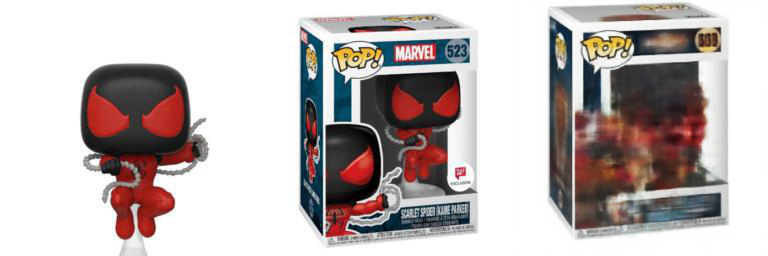

In [16]:
#!g1.1
x_try, y_try = list_val[13]
generate_images_PIL(g, x_try, y_try, norm=True)

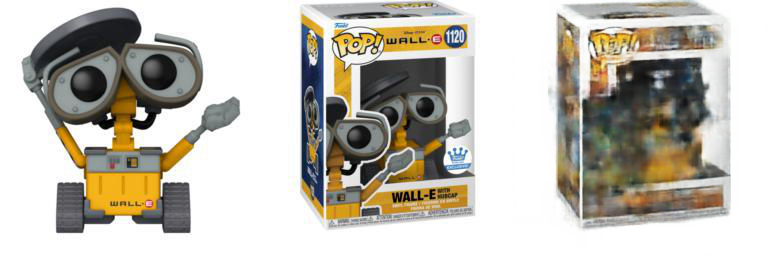

In [14]:
#!g1.1
x_try, y_try = list_val[55]
generate_images_PIL(g, x_try, y_try, norm=True)

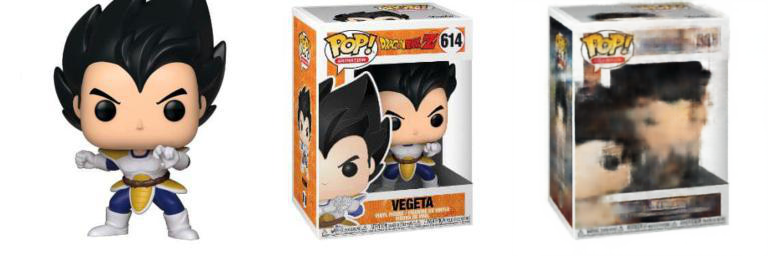

In [15]:
#!g1.1
x_try, y_try = list_val[89]
generate_images_PIL(g, x_try, y_try, norm=True)

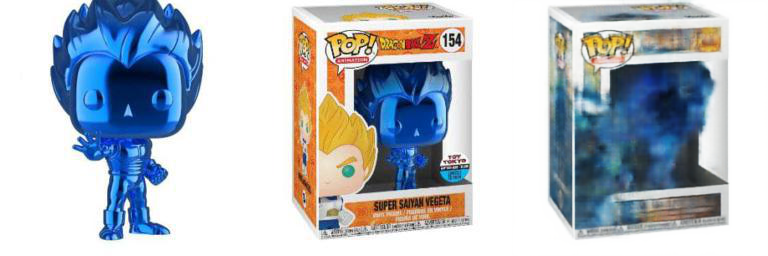

In [17]:
#!g1.1
x_try, y_try = list_val[49]
generate_images_PIL(g, x_try, y_try, norm=True)

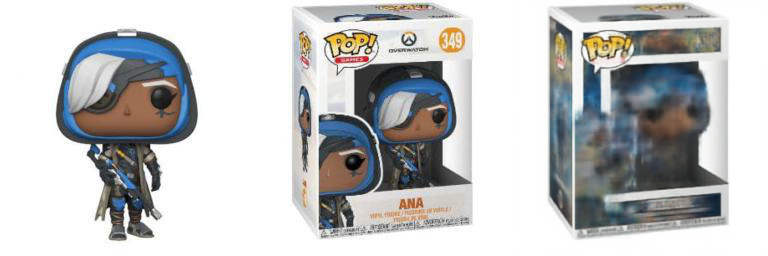

In [18]:
#!g1.1
x_try, y_try = list_val[32]
generate_images_PIL(g, x_try, y_try, norm=True)

Надписи POP! всегда довольно четкие, номер не всегда видно (даже кружок номера не всегда различим)

# Модель Дискриминатора

In [ ]:
class DiscriminatorBlock(nn.Module): 
    def __init__(self, 
                 input_ch, 
                 output_ch, 
                 kernel_size=4,
                 stride=2,
                 padding=1,
                 norm=True,
                 slope=0.2):
        super(DiscriminatorBlock, self).__init__()
        self.input_ch, self.output_ch = input_ch, output_ch
        conv_list = [nn.Conv2d(input_ch, 
                               output_ch, 
                               kernel_size,
                               stride,
                               padding)]
        if norm:
            conv_list.append(nn.InstanceNorm2d(output_ch))
        conv_list.append(nn.LeakyReLU(slope)) #All ReLUs in the encoder are leaky, with slope 0.2
        self.conv_net = nn.Sequential(*conv_list)
    def forward(self, x):
        x = self.conv_net(x)
        return x


class Discriminator(nn.Module):
    def __init__(self, 
                 input_ch=3,
                 output_ch=1,
                 kernel=4,
                 padding=1):
        super(Discriminator, self).__init__()
      
        self.block_net = nn.Sequential(
            DiscriminatorBlock(input_ch * 2, 64, norm=False),
            DiscriminatorBlock(64, 128),
            DiscriminatorBlock(128, 256),
            DiscriminatorBlock(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, output_ch, kernel, padding=padding, bias=False)

        )


    def forward(self, x_img, y_img):
        x = torch.cat((x_img, y_img), 1)
        out = self.block_net(x)
        return out

# Обучение финальной модели (с дискриминатором)

## Функиции потерь и обучения

In [ ]:
def gentrator_loss(discriminator_generator_output, generator_output, target, lambda_=100):
    l1_loss = F.l1_loss(generator_output, target)
    gan_loss = F.binary_cross_entropy_with_logits(
                              discriminator_generator_output,
                              torch.ones_like(
                                   discriminator_generator_output)
                              )
    return l1_loss * lambda_ + gan_loss, gan_loss.item(), l1_loss.item()

In [ ]:
def discriminator_loss(real_discriminator_output, fake_discriminator_output):
    real_loss = F.binary_cross_entropy_with_logits(real_discriminator_output,
                                                   torch.ones_like(real_discriminator_output)
                                                   )
    fake_loss = F.binary_cross_entropy_with_logits(fake_discriminator_output,
                                                   torch.zeros_like(fake_discriminator_output),
                                                   )
    return real_loss + fake_loss

In [ ]:

def train(generator,
          discriminator,
          n_epochs,
          generator_opt,
          discriminator_opt,
          train_loader,
          val_loader=None,
          num_model=0,
          best_loss=None,
          logging=False
          ):
    best_loss = best_loss

    generator.train()
    generator = generator.to(DEVICE)

    discriminator.train()
    discriminator = discriminator.to(DEVICE)
  

    for epoch in range(n_epochs):
        g_loss, d_loss, gan_loss, l1_loss = train_epoch(generator,
                                       discriminator,
                                       generator_opt,
                                       discriminator_opt,
                                       train_loader,
                                       logging)
        print('\nepoch ' + str(epoch) + '/' + str(n_epochs), 'g loss', g_loss, 'd_loss' , d_loss)
        torch.save(generator.state_dict(), 'pix2pix/gen_' + str(num_model) +'.pt')
        torch.save(discriminator.state_dict(), 'pix2pix/dis_' + str(num_model) +'.pt')
        #torch.save(generator.state_dict(), 'gen_' + str(num_model) +'.pt')
        if logging:
            wandb.log({
                'train_g_loss' : g_loss,
                'train_d_loss' : d_loss,
                'train_gan_loss' : gan_loss,
                'train_l1_loss' : l1_loss

            })
        if val_loader is not None:
            g_loss, d_loss, gan_loss, l1_loss = validation(generator,
                                    discriminator,
                                    val_loader, 
                                    logging)
            print('\nval ' + str(epoch) + '/' + str(n_epochs), 'g loss', g_loss, 'd_loss', d_loss )
            if logging:
                wandb.log({
                   'val_g_loss' : g_loss,
                   'val_d_loss' : d_loss,
                   'val_gan_loss' : gan_loss,
                   'val_l1_loss' : l1_loss
            })
        #if best_loss is None or g_loss < best_loss:
         #   best_loss = g_loss
          #  torch.save(generator.state_dict(), 'pix2pix/best_gen_' + str(num_model) +'.pt')
           # torch.save(discriminator.state_dict(), 'pix2pix/best_dis_' + str(num_model) +'.pt')
            #torch.save(generator.state_dict(), 'best_gen_' + str(num_model) +'.pt')
            
        
  
def train_epoch(generator,
                discriminator,
                opt_generator,
                opt_discriminator,
                train_loader,
                logging=False):
    
    
    g_loss_ = 0
    d_loss_ = 0
    gan_loss_ = 0
    l1_loss_ = 0
    step_ = 0
    for x, y in train_loader:

        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        print(step_, end='\t')
        step_ += 1
        

        #Обучение дискриминатораа#
        #Генератор НЕ обучатся
        #########
        for param in discriminator.parameters():
            param.require_grad = True
        for param in generator.parameters():
            param.require_grad = False
        opt_discriminator.zero_grad()
      
        discr_output_real = discriminator(y, x)
        fake = generator(x)
        #Мы не пробрасываем градиент сквозь генератор, делаем detach
      
        discr_output_fake = discriminator(fake.detach(), x)
        
        loss_discriminator = discriminator_loss(discr_output_real, 
                                                discr_output_fake) * 0.5
        real_loss_disc = loss_discriminator.item() * 2
        d_loss_ += real_loss_disc
        loss_discriminator.backward()
        opt_discriminator.step()
        #########

        if logging:
            wandb.log({
                'train_step_d_loss' : real_loss_disc
            })
        
        #Обучение генератора#
        #Дискриминатор НЕ обучатся
        #########
        for param in generator.parameters():
            param.require_grad = True
        for param in discriminator.parameters():
            param.require_grad = False
        opt_generator.zero_grad()
        
        #discr_output_real = discriminator(y, x)
        #fake = generator(x)
        discr_output_fake = discriminator(fake, x)
        
        loss_generator, loss_gan, loss_l1 = gentrator_loss(discr_output_fake, fake, y)
        
        g_loss_ += loss_generator.item()
        gan_loss_ += loss_gan
        l1_loss_ += loss_l1


        loss_generator.backward()
        opt_generator.step()
        ##########

        if logging:
            wandb.log({
                'train_step_g_loss' : loss_generator.item(),
                'train_step_gan_loss':loss_gan,
                'train_step_l1_loss':loss_l1
            })
        



         
    if logging:
        wandb.log({
          'train_real' :  wandb.Image(F_.to_pil_image(x[0] * 0.5 + 0.5)),
          'train_truth' :  wandb.Image(F_.to_pil_image(y[0] * 0.5 + 0.5)),
          'train_fake' :  wandb.Image(F_.to_pil_image(fake[0] * 0.5 + 0.5))
      })

    return g_loss_ / len(train_loader), d_loss_ / len(train_loader), gan_loss_ / len(train_loader), l1_loss_ / len(train_loader)


def validation(generator,
                 discriminator,
                 val_loader,
                 logging=False):
    
    
    g_loss_, d_loss_ = 0, 0
    step_ = 0
    gan_loss_ = 0
    l1_loss_ = 0
    
    generator.eval()
    generator = generator.to(DEVICE)
    
    discriminator.eval()
    discriminator = discriminator.to(DEVICE)

    with torch.no_grad():
        for x, y in val_loader:

            x = x.to(DEVICE)
            y = y.to(DEVICE)
            
            print(step_, end='\t')
            step_ += 1

            discr_output_real = discriminator(y, x)
            fake = generator(x)
            discr_output_fake = discriminator(fake, x)
        
            loss_discriminator = discriminator_loss(discr_output_real, 
                                                discr_output_fake)
            d_loss_ += loss_discriminator.item()
        
            loss_generator, loss_gan, loss_l1 = gentrator_loss(discr_output_fake, fake, y)
        
            g_loss_ += loss_generator.item()
            gan_loss_ += loss_gan
            l1_loss_ += loss_l1

            if logging:
                wandb.log({
                    'val_step_d_loss' : loss_discriminator.item(),
                    'val_step_g_loss' : loss_generator.item(),
                    'val_step_gan_loss':loss_gan,
                    'val_step_l1_loss':loss_l1
                })
            
        if logging:
            wandb.log({
              'val_real' :  wandb.Image(F_.to_pil_image(x[0] * 0.5 + 0.5)),
              'val_truth' :  wandb.Image(F_.to_pil_image(y[0] * 0.5 + 0.5)),
              'val_fake' :  wandb.Image(F_.to_pil_image(fake[0] * 0.5 + 0.5))
          })
    return g_loss_ / len(val_loader), d_loss_ / len(val_loader), gan_loss_ / len(val_loader), l1_loss_ / len(val_loader)



     

## Обучение генератора и дискриминатора

ВАЖНО: аутпут обучения ниже: это аутпут для последней модели с докинутыми аугами цветов. Версию ноутбука с обучением изначальной модели на фанко попах я не сохаранила( Однако из этого аутпута видно, что все обучается и логгируется

In [ ]:
#!g1.1
#Добавила цвет-ауги
#wandb.init(project='funkopops GAN')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

g = UNetModel()
d = Discriminator()

g_opt = torch.optim.Adam(g.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_opt = torch.optim.Adam(d.parameters(), lr=0.0002, betas=(0.5, 0.999))

train(g,
          d,
          n_epochs=50,
          generator_opt=g_opt,
          discriminator_opt=d_opt,
          train_loader=train_loader,
          val_loader=val_loader,
          num_model=701,
          logging=True
          )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kogana00 (use `wandb login --relogin` to force relogin)


0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	47	48	49	50	51	52	53	54	55	56	57	58	59	60	61	62	63	64	65	66	67	68	69	70	71	72	73	74	75	76	77	78	79	80	81	82	83	84	85	86	87	88	89	90	91	92	93	94	95	96	97	98	99	100	101	102	103	104	105	106	107	108	109	110	111	112	113	114	115	116	117	118	119	120	121	122	123	124	125	126	127	128	129	130	131	132	133	134	135	136	137	138	139	140	141	142	143	144	145	146	147	148	149	150	151	152	153	154	155	156	157	158	159	160	161	162	163	164	165	166	167	168	169	170	171	172	173	174	175	176	177	178	179	180	181	182	183	184	185	186	187	188	189	190	191	192	193	194	195	196	197	198	199	200	201	202	203	204	205	206	207	208	209	210	211	212	213	214	215	216	217	218	219	220	221	222	223	224	225	226	227	228	229	230	231	232	233	234	235	236	237	238	239	240	241	242	243	244	245	246	247	248	249	250	251	252	253	254	255	256	257	258	259	260	261	262	263	264	265	266	267	268	269	270	271	272	273	274	275	276	27

In [ ]:
#!g1.1
#wandb.finish()

train_d_loss,█▇▇▇▆▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▂▅▂▃▂▂▂▂▂▂▁▂▃
train_g_loss,█▇▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_gan_loss,▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▇▆▇▇██████
train_l1_loss,█▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_step_d_loss,▂▄▁▆▁▃▂▇▄▄▅▅▂▆▃▄▄▆▃▄▃▆█▂▂▂▁▃▃▂▂▂▁▂▁▂▂▃▃▂
train_step_g_loss,█▄█▃▇▄▆▂▆▅▂▃▄▂▆▂▂▄▆▁▂▆▂▄▂▃▅▂▁▄▁▁▄▄▄▃▁▇▄▂
train_step_gan_loss,▃▂▆▂▆▃▄▁▃▆▂▃▃▃▅▄▃▅▅▄▃█▇▅▆▄█▄▄▇▃▅▆▅▆▆▄▇▆▇
train_step_l1_loss,█▄▇▃▆▄▆▃▆▄▃▃▅▂▅▃▂▄▆▁▂▅▁▄▁▃▄▂▁▄▁▁▃▄▄▂▁▆▃▂
val_d_loss,▅▆▃▃▄▄▅▄▅▅▄▄▄▆█▅▃▃▄▆▃▄▆▃▄▂▂▆▂▄▃▃▃▃▂▂▁▁▂▁
val_g_loss,▇█▆▄▅▃▃▂▃▄▃▃▂▅▆▁▃▃▁▅▂▅▆▅▆▄▅█▅▅▂▆▇▇▅▇▃▆▃▅
val_gan_loss,▂▃▃▂▂▂▁▁▂▃▂▃▂▅▅▁▃▃▂▅▂▆▇▅▇▅▆█▆▆▃▇██▆█▅▇▄▇


# Тестирование генератора, обученного с дискриминатором

In [19]:
#!g1.1
g = UNetModel()
#Первая модель (без аугов, дискриминатор-генератор) носит название first
g.load_state_dict(torch.load('/content/drive/MyDrive/pix2pix/first.pt'))

<All keys matched successfully>

## Подсчет fid - количественная оценка

In [21]:
#!g1.1
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
g.eval()
fake_folder = 'fake_funko_first_box/'
real_folder = 'real_funko_first_box/'

if not os.path.exists(fake_folder):
    os.makedirs(fake_folder)

if not os.path.exists(real_folder):
    os.makedirs(real_folder)

    
    
ii=0
g =  g.to(DEVICE)
for x, real in val_loader:
    fake = g(x.to(DEVICE))
    
    fake_img = F_.to_pil_image(fake[0] * 0.5 + 0.5)
    real_img = F_.to_pil_image(real[0] * 0.5 + 0.5)
    fake_img.save(fake_folder + str(ii) + '.jpg')
    real_img.save(real_folder + str(ii) + '.jpg')
    ii += 1


In [22]:
!pip install pytorch-fid==0.2.1

In [23]:
!python -m pytorch_fid /content/fake_funko_first_box/ /content/real_funko_first_box/

100% 2/2 [00:00<00:00,  3.43it/s]
100% 2/2 [00:00<00:00,  3.76it/s]
FID:  134.9010887011018


Было 199.9, стало 134. Прогресс

## Примеры работы - качественная оценка

In [24]:
#!g1.1
def generate_images_PIL(generator, x, y, norm=False):
    x = x.to(DEVICE)
    y = y.to(DEVICE)
    generator = generator.to(DEVICE) 
    generator.eval()
    with torch.no_grad():
        fake = generator(x).detach().cpu()
    #plt.figure(figsize=(15, 15))
    
    display_list = [x[0], y[0], fake[0]]
    #title = ['Input Image', 'Ground Truth', 'Predicted Image']

    new_img = PIL.Image.new('RGB',(256*3,256))

    for i in range(3):
        #plt.subplot(1, 3, i+1)
        #plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        if not norm:
            new_img.paste(F_.to_pil_image(display_list[i]), (256*i, 0))
        else:
            new_img.paste(F_.to_pil_image(display_list[i] * 0.5 + 0.5), (256*i, 0))

        #plt.axis('off')
    #plt.show()
    return new_img

In [25]:
#!g1.1
val_list = list(val_loader)

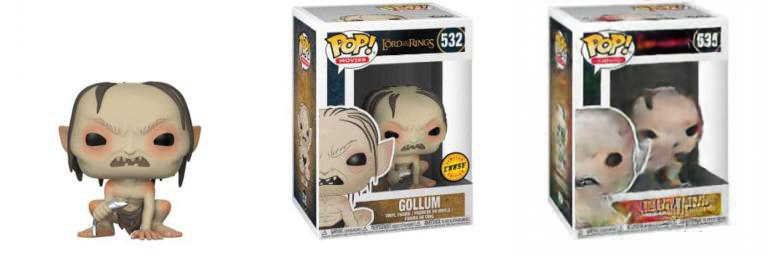

In [26]:
#!g1.1
x_try, y_try = val_list[90]
generate_images_PIL(g, x_try, y_try, norm=True)

Хей, даже оскал уловился! И номер почти угадался!

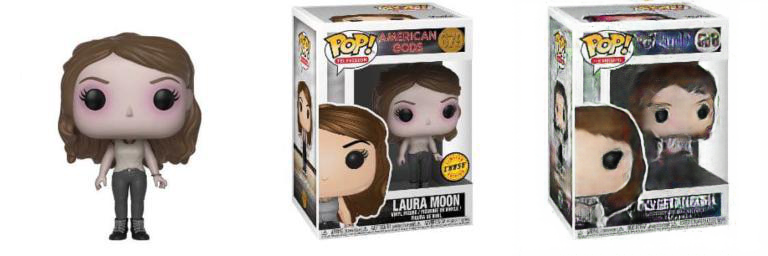

In [28]:
#!g1.1
x_try, y_try = val_list[0]
generate_images_PIL(g, x_try, y_try, norm=True)

Круги под глазами потерялись, зато прическа норм (даже пробор в нужном месте)

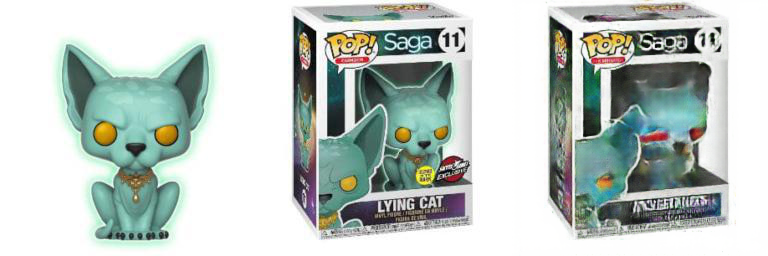

In [31]:
#!g1.1
x_try, y_try = val_list[3]
generate_images_PIL(g, x_try, y_try, norm=True)

Та самая супер-кошка. Хорошо отрисовало. Только почему же глаза красные?

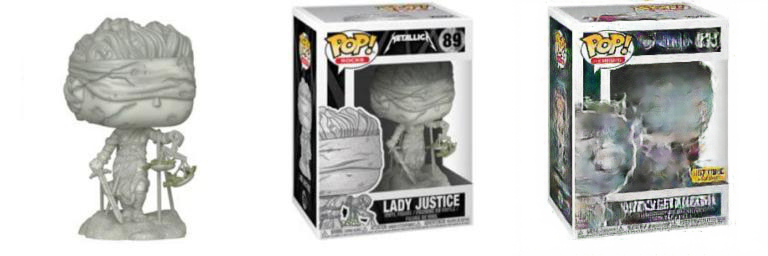

In [45]:
#!g1.1
x_try, y_try = val_list[17]
generate_images_PIL(g, x_try, y_try, norm=True)

А вот и стикер Hot Topic

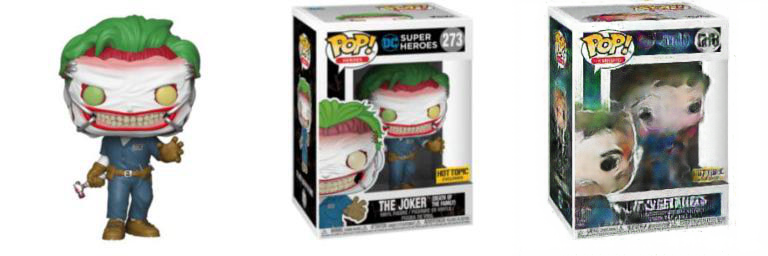

In [46]:
#!g1.1
x_try, y_try = val_list[18]
generate_images_PIL(g, x_try, y_try, norm=True)

О, тут даже угадалось, что нужен стикер